<img src="https://uk-scape.ceh.ac.uk/sites/default/files/images/theme/UK_SCAPE_Logo_Positive_0.png" alt="image" align="left">

# Time series data access
This notebook provides examples of reading time series data from a number of different public web services, using a set of additional 'middleware' web services designed to provide more consistent and standardised access. Node middleware defined below is https://eip.ceh.ac.uk/hydrology-ukscape/help.

Click anywhere on a cell, then hit shift+enter to run the code. Alternatively you can hit the play button in the ribbon at the top of the notebook.

### Import packages

In [1]:
import urllib.request
import json
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as matplt
import matplotlib.dates as mdate

# for map backgrounds
import contextily as cx 

## List of available organisations with datatypes and datasets
You can see these in http://eip.ceh.ac.uk/hydrology-ukscape/stations/ \
Add the organisation ID (for example EA) at the end of the URL to see the datatypes for that particular organisation, as follows:
http://eip.ceh.ac.uk/hydrology-ukscape/stations/EA


### EA (Environment Agency)
#### Datatype: flow
gdf: Gauged daily flow \
gmf: Gauged monthly flow
#### Datatype: rainfall
cdr: Catchment daily rainfall \
cmr: Catcment monthly rainfall
### SEPA (Scottish Environmental Protection Agency)
#### Datatype: rainfall
cdr: Catchment daily rainfall
### COSMOS
#### Datatype: soil-moisture
vwc: Daily volumetric water content \
vwc-m: Monthly volumetric water content
### NRFA (National River Flow Archive)
#### Datatype: flow
gdf: Gauged daily flow \
ndf: Naturalised daily flow \
gmf: Gauged monthly flow \
nmf: Naturalised monthly flow 
#### Datatype: rainfall
cdr: Catchment daily rainfall \
cmr: Catchment monthly rainfall
### MO (Met Office)
#### Datatype: weather
T : Temperature \
F : Feels like temperature \
V: Visibility \
D: Wind direction \
G: Wind gust \
S: Wind speed \
W: Weather type \
P: Pressure \
Pt: Pressure tendency \
Pp Precipitation probability \
Dp: Dew point \
H: Screen relative humidity \
U: Max UV index

## Functions to get list of available stations for given organisation and data type

As these are all *def* commands, running them won't produce a visible output yet.

**Function *get_stations*:** loads in the stations from the node middleware to a geopandas dataframe.

In [9]:
def get_stations(organisationID,dataType,datasetID,middlewareServer='http://eip.ceh.ac.uk/hydrology-ukscape'):
    url = middlewareServer + "/stations/"+str(organisationID)+"/"+str(dataType)
    print('Station url', url)
    stations = dict()
    # fetch the data from the url using the request library
    with urllib.request.urlopen(url) as response:
        try:
            #parse the response as json
            data = json.load(response)
            #create a dataframe of the dataTypes
            responseDataTypes = pd.DataFrame(data['metadata']['dataTypes'])
            idCol = 'id'
            #use the nrfaRef if available as simpler to pass around
            if 'nrfaRef' in responseDataTypes.columns:
                idCol = 'nrfaRef'
            #loop through the dataTypes to get the one that matches the datasetID
            for index, item in responseDataTypes.iterrows():
                if item[idCol] == datasetID:
                    #if the datatype ID matches the current row, then set it as the stations metadata. 
                    stations['metadata'] = item
                    #create a pandas dataframe of the station list from the response 
                    stations['df'] = pd.DataFrame(data['data']);
                    #print(stations['df'])
                    #convert to geopandas dataframe so can use the geometry to plot a map
                    stations['gdf'] = gpd.GeoDataFrame(stations['df'], geometry=gpd.points_from_xy(stations['df'].longitude, stations['df'].latitude))
                    return stations
                    break
        except: 
            print('Error, cannot fetch data')
        else:
            stations = dict()        

**Function *get_timeseries_data*:** gathers the timeseries data of a station by its reference.

In [10]:
def get_timeseries_data(stationRef,organisationID,datasetID,middlewareServer='http://eip.ceh.ac.uk/hydrology-ukscape'):
    #get the data from node middleware as csv
    url = middlewareServer + "/stations/"+str(organisationID)+"/"+str(datasetID)+"/"+str(stationRef)+"/2017-01-01/2020-12-31"
    print('Timeseries url',url)
    #read json into dataframe
    timeseries_df = None
    try:
        # fetch the data from the url using the request library
        with urllib.request.urlopen(url) as response:
            #parse the response as json
            data = json.load(response)
            if isinstance(data['data'], list):
                #create a pandas dataframe of the timeseries data from the response 
                timeseries_df = pd.DataFrame(data['data'])
            #Met office has observed and forecast data
            else:
                #print(data['data'])
                timeseries_df = pd.concat([pd.DataFrame(data['data']['observedData']),pd.DataFrame(data['data']['forecastData'])])
                timeseries_df = timeseries_df.sort_values('datetime', axis=0)
            #print(timeseries_df.head(5))
            return timeseries_df
    except urllib.error.HTTPError as e:
        print(e.code)
        print('No timeseries data available for this query.')  

**Function *draw_Matplt_Plot*:** used to draw a mapplotlib plot of timeseries data.

In [11]:
def draw_Matplt_Plot(stationID, df, metadata):
    #print(metadata)
    fig = matplt.figure(figsize=(12,8))
    matplt.plot(df['datetime'], df['value'])
    matplt.xlabel('Date')
    matplt.ylabel(metadata['parameter'] +' ('+ metadata['units']+')')
    matplt.title(metadata['name'] + ' plot for '+str(stationID))
    matplt.grid()
    #only show months on xaxis ticks
    locator = mdate.YearLocator()
    matplt.gca().xaxis.set_minor_locator(locator)
    matplt.gcf().autofmt_xdate()
    matplt.show()

## Example: plot a set of stations from an organisation on a map
organisationID = 'EA' \
datatype = 'flow' \
datasetID = 'gdf'  

Station url http://eip.ceh.ac.uk/hydrology-ukscape/stations/EA/flow
id                  flow-m-86400-m3s-qualified
name                           Daily mean flow
parameter                                 flow
nrfaRef                                    gdf
units                                     m3/s
period                                     P1D
measurement-type                          mean
calculateMonthly                           NaN
Name: 0, dtype: object
         id                                   ref                name  \
0  SW73F053  951f7162-24d4-45f4-a03e-ee55d3c864c1          Ponsanooth   
1    3850TH  d9f8ae6e-a12e-4fbf-972e-21c89e521789  Brent (Monks Park)   
2     F1707  655a16a0-8498-4b83-a8f6-6816952b2262              Armley   
3    030028  32f5b1ea-29f7-4d6c-b473-a9e5da0e59d1          Banks Road   
4    030027  8e8296b1-6e4d-49e3-a197-cfcd0962e1b3       Victoria Mill   

  organisation                                       otherStation   latitude  \
0           EA

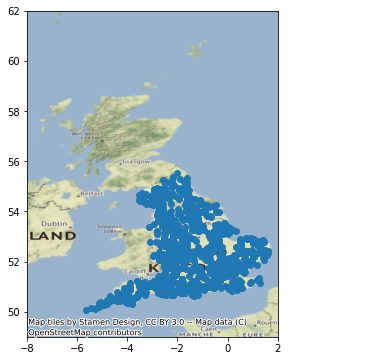

In [16]:
#set some parameters to fetch a particular station list
params_1 = {
    'organisationID': 'EA',
    'datatype': 'flow',
    'datasetID': 'gdf'   
}
#stations = get_stations(organisationID, datatype, datasetID)
ea_stations = get_stations(params_1['organisationID'],params_1['datatype'],params_1['datasetID'])
print(ea_stations['metadata'])
print(ea_stations['gdf'].head(5))
#Plot the stations to a matplotlib plot
ax = ea_stations['gdf'].plot(figsize=[5,6])
ax.set_xlim([-8,2])
ax.set_ylim([49,62])
cx.add_basemap(ax, zoom=6, crs="epsg:4326")

### Show the timeseries data for a station in Matplotlib
Get the timeseries data by inputting a station reference from the station list, organisation ID and datasetID.

Station reference (ref) 887950f8-6b72-48c3-8f25-b32c6a0e688b


Timeseries url http://eip.ceh.ac.uk/hydrology-ukscape/stations/EA/gdf/887950f8-6b72-48c3-8f25-b32c6a0e688b/2017-01-01/2020-12-31


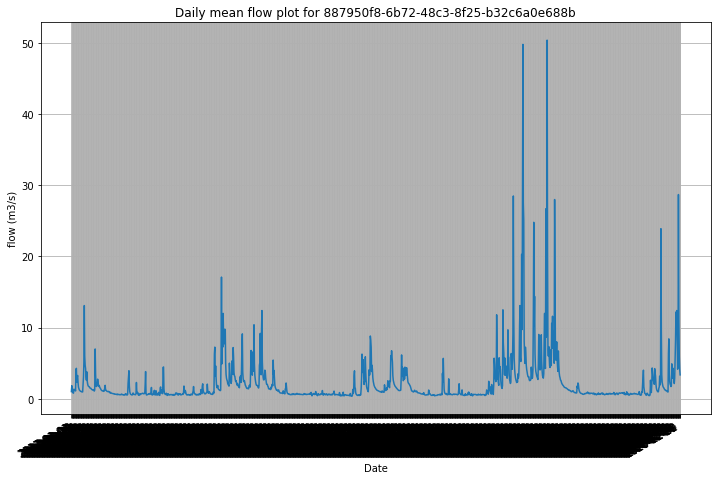

In [18]:
# add this to previous params_1
params_1['stationRef'] = input('Station reference (ref)')
timeseries_df = get_timeseries_data(params_1['stationRef'], params_1['organisationID'], params_1['datasetID'])
#Draw a matplotlib plot of the timeseries data
try:
    draw_Matplt_Plot(params_1['stationRef'], timeseries_df, ea_stations['metadata'])
except:
    print('Invalid station ID or no data')

### Example: lets try a different organisation
organisationID = 'MO' (Met Office) \
datatype = 'weather' \
datasetID = 'T' (temperature)

Station url http://eip.ceh.ac.uk/hydrology-ukscape/stations/MO/weather
id                     T
units                  C
name         Temperature
parameter        weather
Name: 0, dtype: object
     id   ref                        name organisation  latitude  longitude  \
0  3066  3066                     Kinloss           MO   57.6494    -3.5606   
1  3068  3068                 Lossiemouth           MO   57.7120    -3.3220   
2  3075  3075  Wick John O Groats Airport           MO   58.4540    -3.0890   
3  3002  3002                  Baltasound           MO   60.7490    -0.8540   
4  3005  3005         Lerwick (S. Screen)           MO   60.1390    -1.1830   

                    geometry  
0  POINT (-3.56060 57.64940)  
1  POINT (-3.32200 57.71200)  
2  POINT (-3.08900 58.45400)  
3  POINT (-0.85400 60.74900)  
4  POINT (-1.18300 60.13900)  


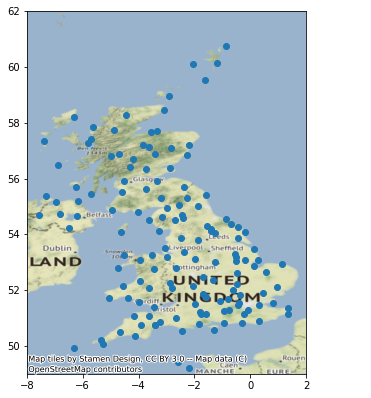

In [19]:
#set some parameters to fetch a particular station list
params_2 = {
   'organisationID': 'MO', #Met Office
   'datatype': 'weather',
   'datasetID': 'T' # temperature
}

#stations = get_stations(organisationID, datatype, datasetID)
mo_stations = get_stations(params_2['organisationID'],params_2['datatype'],params_2['datasetID'])
print(mo_stations['metadata'])
print(mo_stations['gdf'].head(5))
#Plot the stations to a matplotlib plot
ax = mo_stations['gdf'].plot(figsize=[5,8])
ax.set_xlim([-8,2])
ax.set_ylim([49,62])
cx.add_basemap(ax, zoom=6, crs="epsg:4326")

Station reference (ref) 3148


Timeseries url http://eip.ceh.ac.uk/hydrology-ukscape/stations/MO/T/3148/2017-01-01/2020-12-31
             datetime value      type
0   2022-12-06T09:00Z    -1  forecast
1   2022-12-06T12:00Z     1  forecast
2   2022-12-06T15:00Z     1  forecast
3   2022-12-06T18:00Z     0  forecast
4   2022-12-06T21:00Z    -1  forecast
5   2022-12-07T00:00Z    -1  forecast
6   2022-12-07T03:00Z    -2  forecast
7   2022-12-07T06:00Z    -2  forecast
8   2022-12-07T09:00Z    -2  forecast
9   2022-12-07T12:00Z    -2  forecast
10  2022-12-07T15:00Z    -2  forecast
11  2022-12-07T18:00Z    -2  forecast
12  2022-12-07T21:00Z    -2  forecast
13  2022-12-08T00:00Z    -3  forecast
14  2022-12-08T03:00Z    -4  forecast
15  2022-12-08T06:00Z    -5  forecast
16  2022-12-08T09:00Z    -4  forecast
17  2022-12-08T12:00Z    -3  forecast
18  2022-12-08T15:00Z    -3  forecast
19  2022-12-08T18:00Z    -4  forecast
20  2022-12-08T21:00Z    -3  forecast
21  2022-12-09T00:00Z    -3  forecast
22  2022-12-09T03:00Z    -2  fo

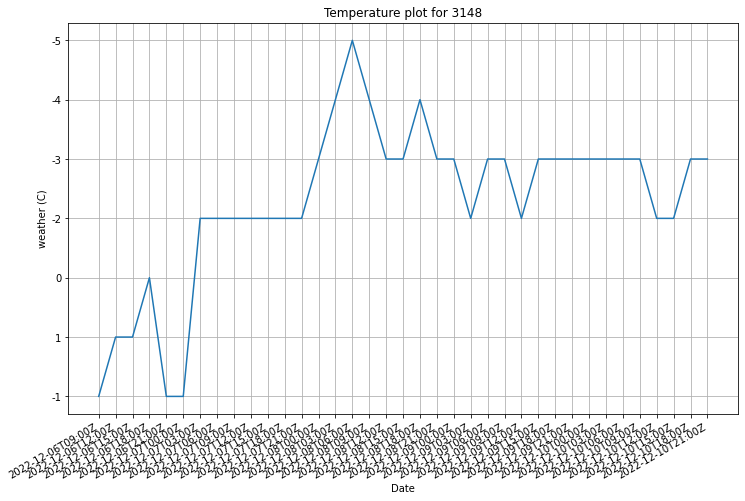

In [21]:
# add this to previous params_2
params_2['stationRef'] = input('Station reference (ref)')
timeseries_df_2 = get_timeseries_data(params_2['stationRef'], params_2['organisationID'], params_2['datasetID'])
print(timeseries_df_2)
#Draw a matplotlib plot of the timeseries data
try:
    draw_Matplt_Plot(params_2['stationRef'], timeseries_df_2, mo_stations['metadata'])
except:
    print('Invalid station ID or no data')